# Surface wave and receiver function - joint inversion (field data)

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_rf_joint/surface_wave_receiver_function_joint.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we extend the example where CoFI has been used for the inversion of Rayleigh wave phase velocities for a 1D layered earth to a joint inversion where we also account for receiver functions.

In this example, we extend from the synthetic data notebook and apply the joint inversion on a field data presented in the Computer Programs in Seismology (see: https://www.eas.slu.edu/eqc/eqc_cps/TUTORIAL/STRUCT/index.html).

**Learning outcomes**

- A demonstration of CoFI's ability to switch between parameter estimation and ensemble methods.
- An application of CoFI for a joint inversion, here of Rayleigh wave pahse velocity and receiver function data, to a field dataset

## Utilities preparation

In this example, we look at a joint inversion problem of surface wave and receiver function.

We use `pysurf96` for computing the forward step of surface wave, and use
`pyhk` for receiver function calculations.

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso
# !pip install git+https://github.com/inlab-geo/pysurf96.git
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/sw_rf_joint

In [2]:
# If this notebook is run locally pysurf96 needs to be installed separately by uncommenting the following line, 
# that is by removing the # and the white space between it and the exclammation mark.
# !pip install -U cofi git+https://github.com/inlab-geo/pysurf96.git@ctypes

In [3]:
import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import arviz as az

%pip install git+https://github.com/inlab-geo/pysurf96
import pysurf96
import bayesbay
import cofi
import pyhk

  Cloning https://github.com/inlab-geo/pysurf96 to /private/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/pip-req-build-7wjgarao
  Running command git clone --filter=blob:none --quiet https://github.com/inlab-geo/pysurf96 /private/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/pip-req-build-7wjgarao
  Resolved https://github.com/inlab-geo/pysurf96 to commit bade207c2db1575cad730ac111d356a66e3e207e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
np.seterr(all="ignore");

**Model vector**

In [5]:
# display theory on the 1D model parameterisation
from IPython.display import display, Markdown

with open("../../theory/misc_1d_model_parameterisation.md", "r") as f:
    content = f.read()

display(Markdown(content))

Here we invert for a layered earth that is we assume that at a given location the earth can be describe by a set of layer with infite extension i.e. there are no lateral variation, the earth only varies in the depth direction. The forward solver typically requires the subsurface to be parametrised a certain way and inversion methods frequenly also assume a certain model parameterisation. This example makes use of two appraoche that are frequently employed to parametrise a layered earth. As we will see later both parametrisations can capture a 1D layered earth but for the different inversion methods it is advantegous to choose one over the other. To explore different approaches we need to be able to convert between the different model parameterisations.

<figure>
<img src="https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/layer_cake_voronoi.png?raw=true" >
<figcaption align = "Parmaterisation of a 1D velcoity function using voronoi sites or a layers"> Layer based and voronoi site based parameterisation of a 1D laereed earth where layers have constant velocities </figcaption>
</figure>


***Layer based parameterisation***

In a layer based parameterisation the model vector is given as $\mathbf{m}=(v_1,t_1,...,v_{n-1},t_{n-1},v_n)$ where $t_i$ is the thickness of the $i$-th layer with velocity $v_i$. The last layer is a half space and thus has only a velocity parameter but no thickness parameter. 


```python
[velocity[1], thickness[1], velocity[2], thickness[2], velocity[3], ...,velocity[n-1], thickness[n-1], velocity[n]]
```


***Voronoi sites based parameterisation***

The alternative to explictly parameterising the layer thickness is to use  Voronoi sites and assing to each site a depth and a velocity. HEre the model vector is given as $\mathbf{m}=(d_1,...,d_n,v_1,...,v_n)$ where $d_i$ is the depth for the i-th vronoi site and  $v_i$ the velocity assinged to the layer represented by the voronoi site. In this parameterisation the interface between two layers is given as the halfway depth between the two corresponding Voronoi sites.

```python
[velocity[1], velocity[2], ..., velocity[n], depth[1], depth[2], ..., depth[n]]
```


In [6]:
# layercake model utilities
def form_layercake_model(thicknesses, vs):
    model = np.zeros((len(vs)*2-1,))
    model[1::2] = thicknesses
    model[::2] = vs
    return model

def split_layercake_model(model):
    thicknesses = model[1::2]
    vs = model[::2]
    return thicknesses, vs

In [7]:
# voronoi model utilities
def form_voronoi_model(voronoi_sites, vs):
    return np.hstack((vs, voronoi_sites))

def split_voronoi_model(model):
    voronoi_sites = model[len(model)//2:]
    vs = model[:len(model)//2]
    return voronoi_sites, vs

In [8]:
def voronoi_to_layercake(voronoi_vector: np.ndarray) -> np.ndarray:
    n_layers = len(voronoi_vector) // 2
    velocities = voronoi_vector[:n_layers]
    voronoi_sites = voronoi_vector[n_layers:]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    layercake_vector = np.zeros((2*n_layers-1,))
    layercake_vector[::2] = velocities
    layercake_vector[1::2] = thicknesses
    return layercake_vector

def layercake_to_voronoi(layercake_vector: np.ndarray, first_voronoi_site: float = 0.0) -> np.ndarray:
    n_layers = len(layercake_vector) // 2 + 1
    thicknesses = layercake_vector[1::2]
    velocities = layercake_vector[::2]
    depths = np.cumsum(thicknesses)
    voronoi_sites = np.zeros((n_layers,))
    for i in range(1,len(voronoi_sites)):
        voronoi_sites[i] = 2 * depths[i-1] - voronoi_sites[i-1]
    voronoi_vector = np.hstack((velocities, voronoi_sites))
    return voronoi_vector

**Interfacing to pysurf96**

In [9]:
# display theory on the using the forward solver
with open("../../theory/geo_surface_wave_dispersion2.md", "r") as f:
    content = f.read()

display(Markdown(content))

CoFI relies on other libraries to solve the forward problem. Here we interface to pysurf96 (https://github.com/miili/pysurf96) to obtain the Rayleigh wave phase velocity dispersion curve given layer thicknesses and Vp, Vs and $\rho$ for each layer. In addtion to the forward function we also implement a function to compute a numerical Jacobian via finite differencing.

While surface waves are sensitive to the pressure wave proapgation velocity $V_p$, the shear wave propagtion velocity $V_s$ and the density $\rho$, they however have limited information content and the three parameters are trading of against each other, thus here we assume that the $V_p/V_s$ ratio is constatn that the density is a linear function of $V_p$ and only invert for $V_s$. That is in the following:
$$
V_p=1.77*V_s
$$
and
$$
\rho = 0.32*V_p* 0.77.
$$


In [10]:
VP_VS = 1.77
RHO_VP_K = 0.32
RHO_VP_B = 0.77

In [11]:
# forward through pysurf96
def forward_sw(model, periods):
    thicknesses, vs = split_layercake_model(model)
    thicknesses = np.append(thicknesses, 10)
    vp = vs * VP_VS
    rho = RHO_VP_K * vp + RHO_VP_B
    return pysurf96.surf96(
        thicknesses,
        vp,
        vs,
        rho,
        periods,
        wave="rayleigh",
        mode=1,
        velocity="phase",
        flat_earth=False,
    )

In [12]:
def forward_sw_interp(model, periods):
    pysurf_periods = np.logspace(
        np.log(np.min(periods)), 
        np.log(np.max(periods+1)), 
        60,
        base=np.e, 
    )
    pysurf_dpred = forward_sw(model, pysurf_periods)
    interp_func = scipy.interpolate.interp1d(pysurf_periods, 
                                             pysurf_dpred, 
                                             fill_value="extrapolate")
    dpred = interp_func(periods)
    return dpred

In [13]:
t_shift = 5
t_duration = 25
t_sampling_interval = 0.1
gauss = 1
ray_param_s_km = 0.07

In [14]:
# forward through rf in pyhf
def forward_rf(
    model, 
    t_shift=t_shift, 
    t_duration=t_duration, 
    t_sampling_interval=t_sampling_interval, 
    gauss=gauss, 
    ray_param_s_km=ray_param_s_km,
    return_times=False
):
    h, vs = split_layercake_model(model)
    data = pyhk.rfcalc(ps=0, thik=h, beta=vs, kapa=np.ones((len(vs),))*VP_VS, p=ray_param_s_km, 
                      duration=t_duration, dt=t_sampling_interval, shft=t_shift, gauss=gauss)
    if return_times:
        times = np.arange(len(data)) * t_sampling_interval - t_shift
        return data, times
    else:
        return data

In [15]:
t_shift = 5
t_duration = 70
t_sampling_interval = 0.5

def forward_rf_interp(model, gauss, ray_param):
    dpred, times = forward_rf(model, t_shift, t_duration, t_sampling_interval,
                       gauss=gauss, ray_param_s_km=ray_param, return_times=True)
    interp_func = scipy.interpolate.interp1d(times, dpred, fill_value="extrapolate")
    return interp_func(rf_field_times)

**Numerical Jacobian**

In [16]:
def jacobian(model, data_length, fwd, fwd_kwargs, relative_step=0.01):
    jac = np.zeros((data_length, len(model)))
    original_dpred = fwd(model, **fwd_kwargs)
    for i in range(len(model)):
        perturbed_model = model.copy()
        step = relative_step * model[i]
        perturbed_model[i] += step
        perturbed_dpred = fwd(perturbed_model, **fwd_kwargs)
        derivative = (perturbed_dpred - original_dpred) / step
        jac[:, i] = derivative
    return jac

**Plotting**

In [17]:
def plot_model(model, ax=None, title="model", **kwargs):
    # process data
    thicknesses = np.append(model[1::2], max(model[1::2]))
    velocities = model[::2]
    y = np.insert(np.cumsum(thicknesses), 0, 0)
    x = np.insert(velocities, 0, velocities[0])
    
    # plot depth profile
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 0.5)),
        "alpha": 0.2,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(kwargs)
    ax.step(x, y, where="post", **plotting_style)
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    ax.set_xlabel("Vs (km/s)")
    ax.set_ylabel("Depth (km)")
    ax.set_title(title)
    return ax

In [18]:
def plot_data(x, y, ax=None, scatter=False, xlabel=None, ylabel=None, 
              title="surface wave data", **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    plotting_style = {
        "linewidth": kwargs.pop("linewidth", kwargs.pop("lw", 1)),
        "alpha": 1,
        "color": kwargs.pop("color", kwargs.pop("c", "blue")),
    }
    plotting_style.update(**kwargs)
    if scatter:
        ax.scatter(x, y, **plotting_style)
    else:
        ax.plot(x, y, **plotting_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

In [19]:
def plot_sw_data(rayleigh_phase_velocities, periods, ax=None, scatter=False, 
                 title="surface wave data", **kwargs):
    return plot_data(x=periods, 
                     y=rayleigh_phase_velocities, 
                     ax=ax, 
                     scatter=scatter, 
                     title=title, 
                     xlabel="Periods (s)", 
                     ylabel="Rayleigh phase velocities (km/s)", 
                     **kwargs)

def plot_rf_data(rf_data, rf_times, ax=None, scatter=False,
                 title="receiver function data", **kwargs):
    return plot_data(x=rf_times, 
                     y=rf_data, 
                     ax=ax, 
                     scatter=scatter, 
                     title=title, 
                     xlabel="Times (s)", 
                     ylabel="Receiver function amplitudes", 
                     **kwargs)

## Read data

**Rayleigh observations**

In [20]:
file_surf_data = "../../data/sw_rf_joint/data/SURF/nnall.dsp"

with open(file_surf_data, "r") as file:
    lines = file.readlines()
    surf_data = []
    for line in lines:
        row = line.strip().split()
        if "C" in row:
            surf_data.append([float(e) for e in row[5:8]])

field_d = np.array(surf_data)
field_d_periods = field_d[:,0]
rayleigh_field_d_obs = field_d[:,1]

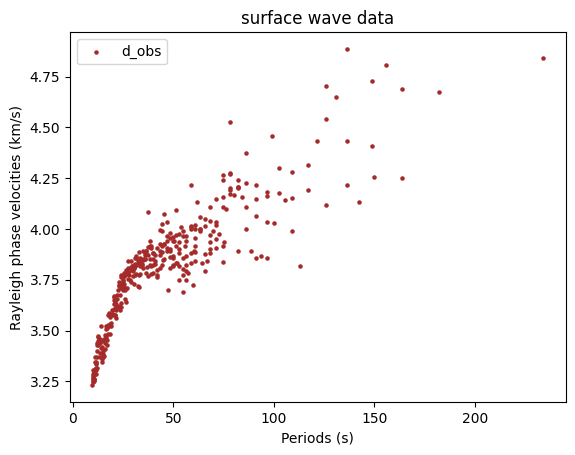

In [21]:
ax = plot_sw_data(rayleigh_field_d_obs, field_d_periods, color="brown", s=5, scatter=True,
             label="d_obs")
ax.legend();

**Receiver function observations**

In [22]:
files_rftn_data = glob.glob("../../data/sw_rf_joint/data/RFTN/rf_*.txt")

all_gauss = []
all_ray_params = []
all_rf_field_dobs = []
rf_field_times = None

for file in files_rftn_data:
    gauss, ray_param_s_km = file.split("_")[-2:]
    all_gauss.append(float(gauss))
    all_ray_params.append(float(ray_param_s_km[:-4]))
    dataset = np.loadtxt(file)
    if rf_field_times is None:
        rf_field_times = dataset[:, 0]
    all_rf_field_dobs.append(dataset[:, 1])

In [23]:
def plot_rf_field_data(all_rf_data, all_gauss, all_ray_params, rf_field_times, 
                       axes=None, color="darkblue", label=None, **kwargs):
    if axes is None:
        _, axes = plt.subplots(13, 3, figsize=(10, 12))
    for i, ax in enumerate(axes.flat):
        ax.set_xlim(-5, 20)
        gauss = all_gauss[i]
        ray_param = all_ray_params[i]
        rf_dobs = all_rf_data[i]
        title=f"ray (s/km) = {ray_param}, gauss = {gauss}"
        plot_rf_data(rf_dobs, rf_field_times, ax=ax, color=color, 
                     title=title, label=label, **kwargs)
        ax.set_ylabel("Amplitude")

    for ax in axes[:-1, :].flat:
        ax.set_xlabel("")
        ax.tick_params(labelbottom=False)
    for ax in axes[:, 1:].flat:
        ax.set_ylabel("")
    plt.tight_layout()
    return axes

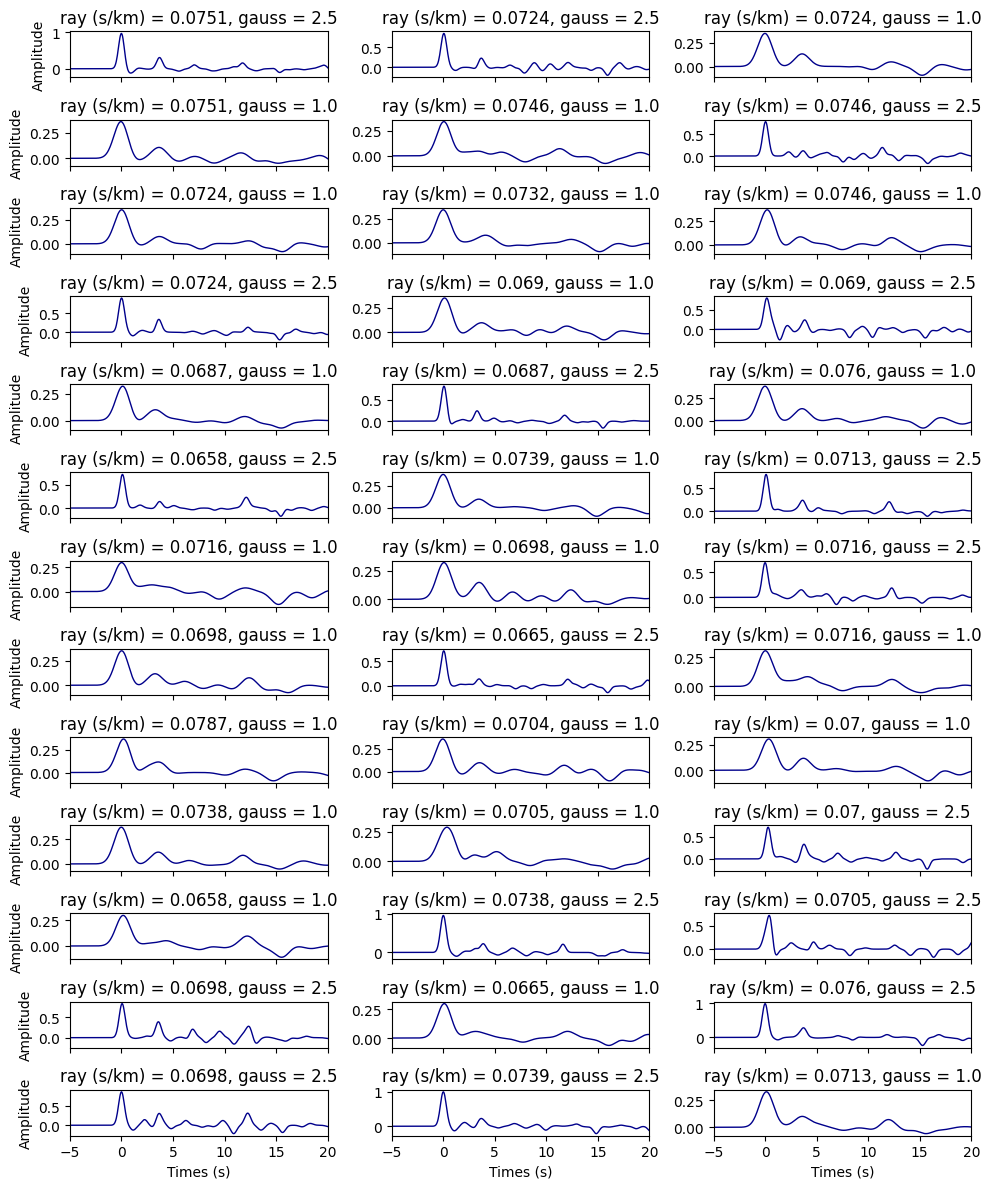

In [24]:
plot_rf_field_data(all_rf_field_dobs, all_gauss, all_ray_params, rf_field_times);

In [25]:
# stacking the data into gauss=1.0 and gauss=2.5 groups
all_rf_field_dobs_1_0 = []
all_rf_field_dobs_2_5 = []
ray_params_1_0 = []
ray_params_2_5 = []
for gauss, ray_param, dobs in zip(all_gauss, all_ray_params, all_rf_field_dobs):
    if gauss == 1:
        all_rf_field_dobs_1_0.append(dobs)
        ray_params_1_0.append(ray_param)
    else:
        all_rf_field_dobs_2_5.append(dobs)
        ray_params_2_5.append(ray_param)

rf_field_dobs_1_0 = np.mean(all_rf_field_dobs_1_0, axis=0)
rf_field_dobs_2_5 = np.mean(all_rf_field_dobs_2_5, axis=0)
ray_param_1_0 = np.mean(ray_params_1_0)
ray_param_2_5 = np.mean(ray_params_2_5)

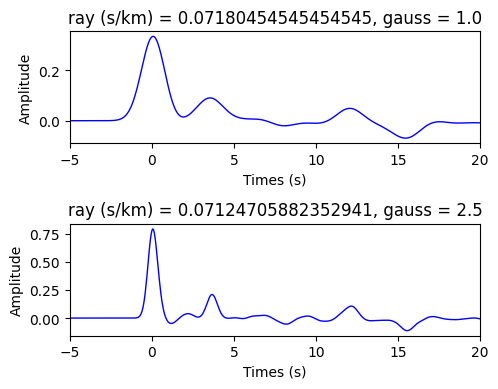

In [26]:
_, axes = plt.subplots(2, 1, figsize=(5,4))

axes[0].set_xlim(-5, 20)
axes[1].set_xlim(-5, 20)

plot_rf_data(
    rf_field_dobs_1_0, 
    rf_field_times, 
    title=f"ray (s/km) = {ray_param_1_0}, gauss = 1.0", 
    ax=axes[0]
)
axes[0].set_ylabel("Amplitude")
plot_rf_data(
    rf_field_dobs_2_5, 
    rf_field_times, 
    title=f"ray (s/km) = {ray_param_2_5}, gauss = 2.5",
    ax=axes[1]
)
axes[1].set_ylabel("Amplitude")
plt.tight_layout()

**Reference good model**

In [27]:
file_end_mod = "../../data/sw_rf_joint/data/JOINT/end.mod"

with open(file_end_mod, "r") as file:
    lines = file.readlines()
    ref_good_model = []
    for line in lines[12:]:
        row = line.strip().split()
        ref_good_model.append([float(row[0]), float(row[2])])

ref_good_model = np.array(ref_good_model)
ref_good_model = form_layercake_model(ref_good_model[:-1,0], ref_good_model[:,1])

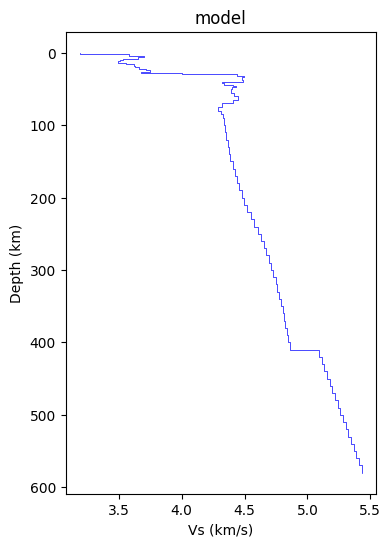

In [28]:
_, ax = plt.subplots(figsize=(4,6))
plot_model(ref_good_model, ax=ax, alpha=1);

## Optimisation

In [29]:
n_dims = 29

init_thicknesses = np.ones((n_dims//2,)) * 10
init_vs = np.ones((n_dims//2+1,)) * 4.0
init_model = form_layercake_model(init_thicknesses, init_vs)

In [30]:
my_reg = cofi.utils.QuadraticReg(
    weighting_matrix="damping", 
    model_shape=(n_dims,), 
    reference_model=init_model
)

In [31]:
def my_objective(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(model, **fwd_kwargs)
        data_misfit += np.sum((d_obs - d_pred) ** 2)
    reg = my_reg(model)
    return data_misfit + lamda * reg

def my_objective_gradient(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit_grad = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(model, **fwd_kwargs)
        jac = jacobian(model, len(d_obs), fwd, fwd_kwargs)
        data_misfit_grad += -2 * jac.T @ (d_obs - d_pred)
    reg_grad = my_reg.gradient(model)
    return data_misfit_grad + lamda * reg_grad

def my_objective_hessian(model, fwd_funcs, d_obs_list, lamda=1.0):
    data_misfit_hess = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        jac = jacobian(model, len(d_obs), fwd, fwd_kwargs)
        data_misfit_hess += 2 * jac.T @ jac
    reg_hess = my_reg.hessian(model)
    return data_misfit_hess + lamda * reg_hess

In [32]:
fwd_funcs = [
    (forward_sw_interp, {"periods": field_d_periods}), 
    (forward_rf_interp, {"gauss": 1, "ray_param": ray_param_1_0}), 
    (forward_rf_interp, {"gauss": 2.5, "ray_param": ray_param_2_5})
]

d_obs_list = [rayleigh_field_d_obs, rf_field_dobs_1_0, rf_field_dobs_2_5]

### Optimisation with no damping

In [33]:
lamda = 0

kwargs = {
    "fwd_funcs": fwd_funcs, 
    "d_obs_list": d_obs_list, 
    "lamda": lamda
}
joint_field_problem_no_reg = cofi.BaseProblem()
joint_field_problem_no_reg.set_objective(my_objective, kwargs=kwargs)
joint_field_problem_no_reg.set_gradient(my_objective_gradient, kwargs=kwargs)
joint_field_problem_no_reg.set_hessian(my_objective_hessian, kwargs=kwargs)
joint_field_problem_no_reg.set_initial_model(init_model)

**Define `InversionOptions`**

In [34]:
inv_options_optimiser = cofi.InversionOptions()
inv_options_optimiser.set_tool("scipy.optimize.minimize")
inv_options_optimiser.set_params(method="trust-exact")

**Define `Inversion` and run**

In [35]:
inv_optimiser_no_reg_field = cofi.Inversion(joint_field_problem_no_reg, inv_options_optimiser)
inv_res_optimiser_field_no_reg = inv_optimiser_no_reg_field.run()

/Users/u8414462/cofi/lib/python3.13/site-packages/cofi/tools/_scipy_opt_min.py:103: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  return minimize(


**Plot results**

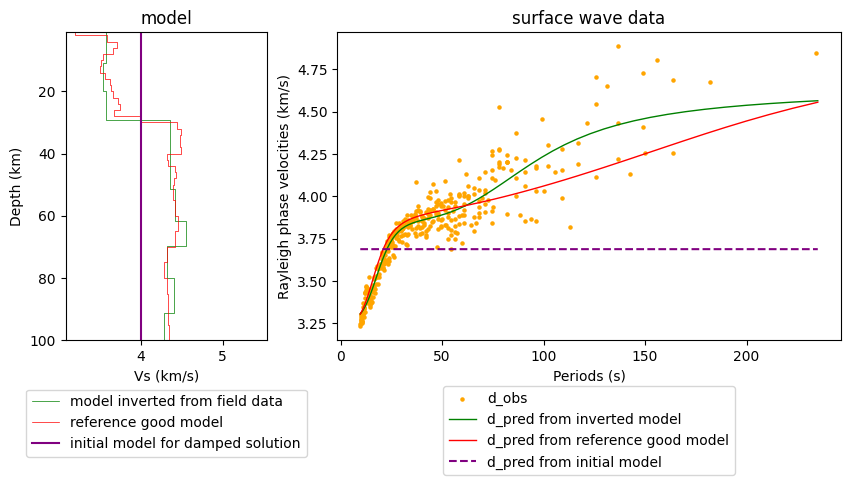

In [36]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

plot_model(inv_res_optimiser_field_no_reg.model, ax=ax1, color="green", alpha=1, 
           label="model inverted from field data")
plot_model(ref_good_model, ax=ax1, color="red", alpha=1, 
           label="reference good model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="purple", 
           label="initial model for damped solution")

field_d_periods_logspace = np.logspace(
    np.log(np.min(field_d_periods)), 
    np.log(np.max(field_d_periods+1)), 
    60, 
    base=np.e, 
)

plot_sw_data(rayleigh_field_d_obs, field_d_periods, ax=ax2, color="orange", s=5, scatter=True, 
             label="d_obs")
plot_sw_data(forward_sw_interp(inv_res_optimiser_field_no_reg.model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="green", 
             label="d_pred from inverted model")
plot_sw_data(forward_sw_interp(ref_good_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="red", 
             label="d_pred from reference good model")
plot_sw_data(forward_sw_interp(init_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, 
             alpha=1, lw=1.5, linestyle="--", color="purple", 
             label="d_pred from initial model")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

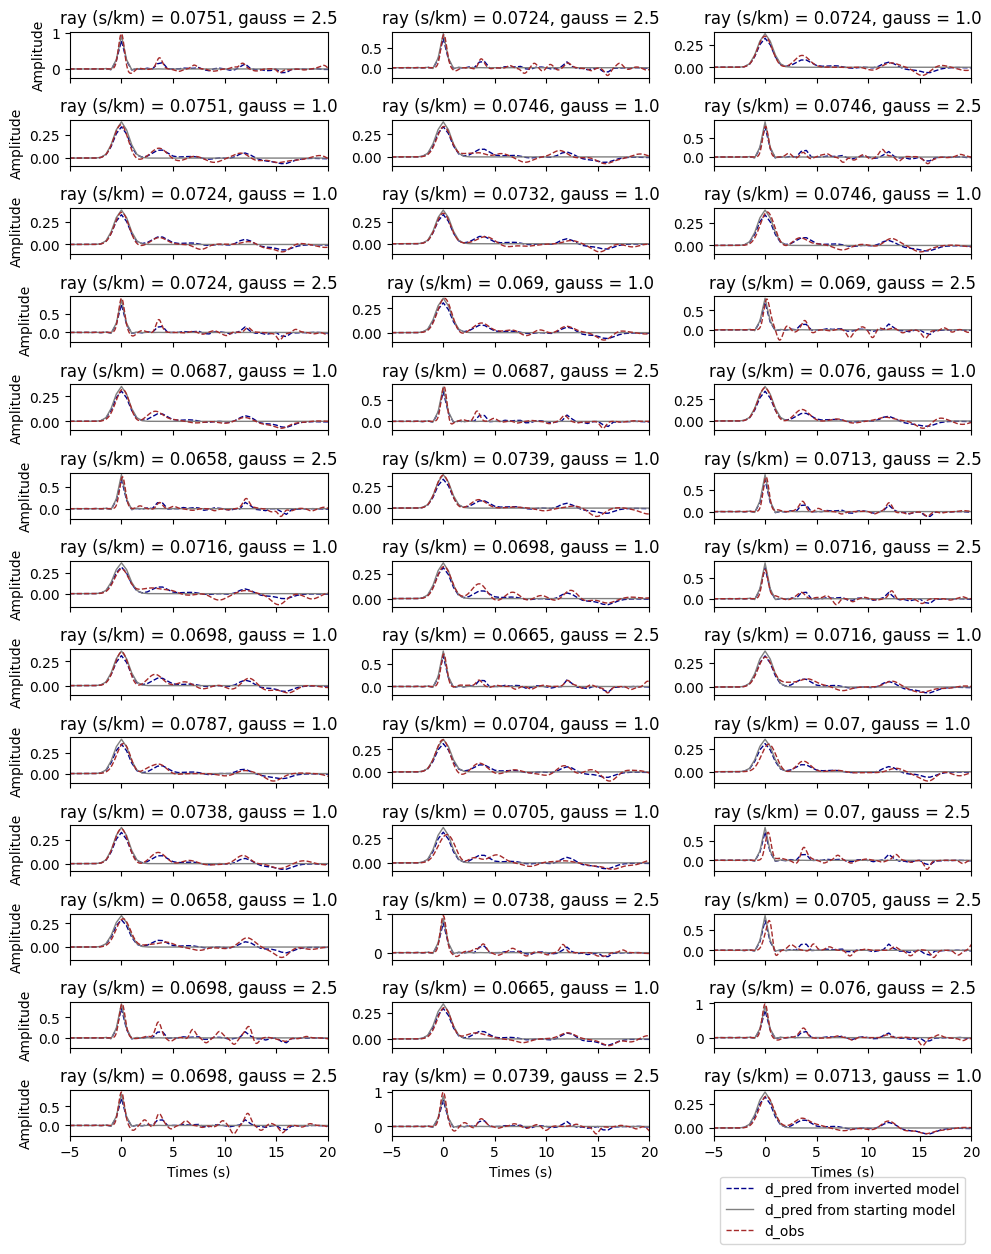

In [37]:
all_rf_dpred = []
all_rf_dpred_init_m = []

for gauss, ray_param in zip(all_gauss, all_ray_params):
    dpred = forward_rf_interp(inv_res_optimiser_field_no_reg.model, gauss, ray_param)
    all_rf_dpred.append(dpred)
    dpred_init_m = forward_rf_interp(init_model, gauss, ray_param)
    all_rf_dpred_init_m.append(dpred_init_m)

axes = plot_rf_field_data(all_rf_dpred, all_gauss, all_ray_params, rf_field_times,
                          color="darkblue", linestyle="dashed", 
                          label="d_pred from inverted model")
plot_rf_field_data(all_rf_dpred_init_m, all_gauss, all_ray_params, rf_field_times,
                   axes=axes, color="gray",
                   label="d_pred from starting model")
plot_rf_field_data(all_rf_field_dobs, all_gauss, all_ray_params, rf_field_times,
                   axes=axes, color="brown", linestyle="dashed", 
                   label="d_obs")

axes[-1,-1].legend(loc="lower center", bbox_to_anchor=(0.5, -2.5));

### Optimal damping

In [38]:
lambdas = np.logspace(-6, 6, 15)

my_lcurve_problems = []
for lamb in lambdas:
    my_problem = cofi.BaseProblem()
    kwargs = {
        "fwd_funcs": fwd_funcs, 
        "d_obs_list": d_obs_list, 
        "lamda": lamb
    }
    my_problem.set_objective(my_objective, kwargs=kwargs)
    my_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
    my_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
    my_problem.set_initial_model(init_model)
    my_lcurve_problems.append(my_problem)

def my_callback(inv_result, i):
    m = inv_result.model
    res_norm = 0
    for (fwd, fwd_kwargs), d_obs in zip(fwd_funcs, d_obs_list):
        d_pred = fwd(m, **fwd_kwargs)
        res_norm += np.sum((d_obs - d_pred) ** 2)
    reg_norm = np.sqrt(my_reg(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=my_lcurve_problems,
    list_of_inv_options=inv_options_optimiser,
    callback=my_callback,
    parallel=False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=1e-06: 4.840610387556389, 4.9693598802758965
Finished inversion with lambda=7.196856730011514e-06: 4.84163385674311, 5.001171227805637
Finished inversion with lambda=5.1794746792312125e-05: 4.875481076310961, 3.104226823067352
Finished inversion with lambda=0.0003727593720314938: 4.853345321578108, 3.344024945018591
Finished inversion with lambda=0.0026826957952797246: 4.847722426056514, 2.9703009898730413
Finished inversion with lambda=0.019306977288832496: 4.882027451222939, 1.9304240097516305
Finished inversion with lambda=0.1389495494373136: 4.930703338278011, 1.7210624612960759
Finished inversion with lambda=1.0: 5.361651713593892, 1.4439173948648252
Finished inversion with lambda=7.196856730011514: 9.115438896354583, 1.0171910241946291
Finished inversion with lambda=51.79474679231202: 26.639472923384435, 0.36821183877071206
Finished inversion with lambda=372.7593720314938: 39.77869947664317, 0.06349209689463897
Finished inversion with lambda=2682.69

In [39]:
# print all the lambdas
lambdas

array([1.00000000e-06, 7.19685673e-06, 5.17947468e-05, 3.72759372e-04,
       2.68269580e-03, 1.93069773e-02, 1.38949549e-01, 1.00000000e+00,
       7.19685673e+00, 5.17947468e+01, 3.72759372e+02, 2.68269580e+03,
       1.93069773e+04, 1.38949549e+05, 1.00000000e+06])

**Plot L-curve**

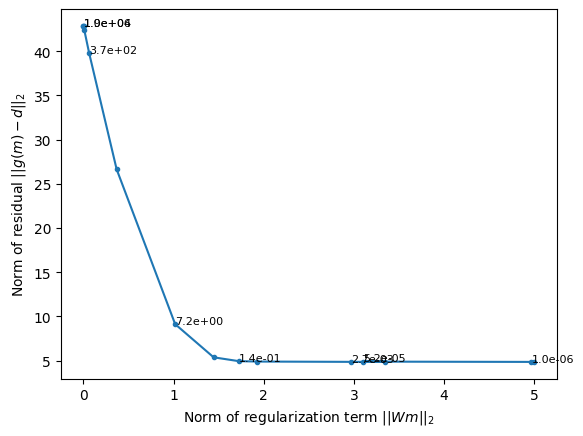

In [40]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 2):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

### Optimisation with damping

In [41]:
lamda = 1

kwargs = {
    "fwd_funcs": fwd_funcs, 
    "d_obs_list": d_obs_list, 
    "lamda": lamda
}
joint_field_problem = cofi.BaseProblem()
joint_field_problem.set_objective(my_objective, kwargs=kwargs)
joint_field_problem.set_gradient(my_objective_gradient, kwargs=kwargs)
joint_field_problem.set_hessian(my_objective_hessian, kwargs=kwargs)
joint_field_problem.set_initial_model(init_model)

**Define `Inversion` and run**

In [42]:
inv_optimiser_field = cofi.Inversion(joint_field_problem, inv_options_optimiser)
inv_res_optimiser_field = inv_optimiser_field.run()

**Plot results**

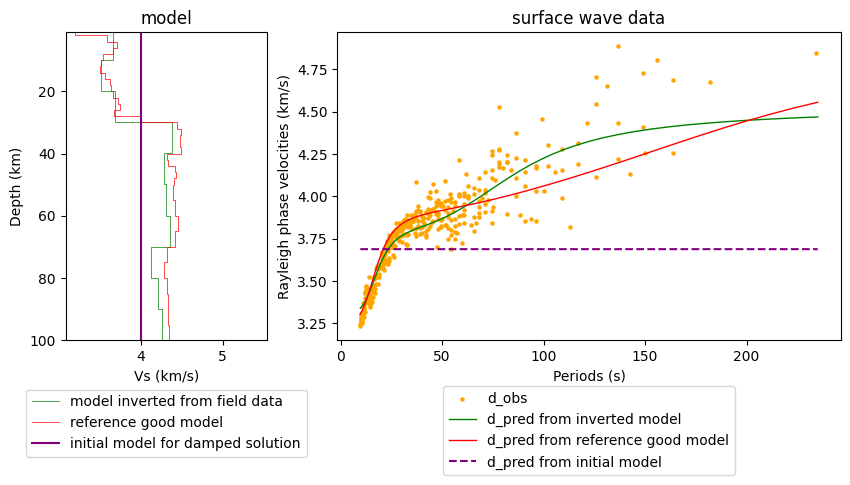

In [43]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2.5]})

ax1.set_ylim(100)

plot_model(inv_res_optimiser_field.model, ax=ax1, color="green", alpha=1, 
           label="model inverted from field data")
plot_model(ref_good_model, ax=ax1, color="red", alpha=1, 
           label="reference good model")
plot_model(init_model, ax=ax1, alpha=1, lw=1.5, color="purple", 
           label="initial model for damped solution")

field_d_periods_logspace = np.logspace(
    np.log(np.min(field_d_periods)), 
    np.log(np.max(field_d_periods+1)), 
    60, 
    base=np.e, 
)

plot_sw_data(rayleigh_field_d_obs, field_d_periods, ax=ax2, color="orange", s=5, scatter=True, 
             label="d_obs")
plot_sw_data(forward_sw_interp(inv_res_optimiser_field.model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="green", 
             label="d_pred from inverted model")
plot_sw_data(forward_sw_interp(ref_good_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="red", 
             label="d_pred from reference good model")
plot_sw_data(forward_sw_interp(init_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, 
             alpha=1, lw=1.5, linestyle="--", color="purple", 
             label="d_pred from initial model")

ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.46));

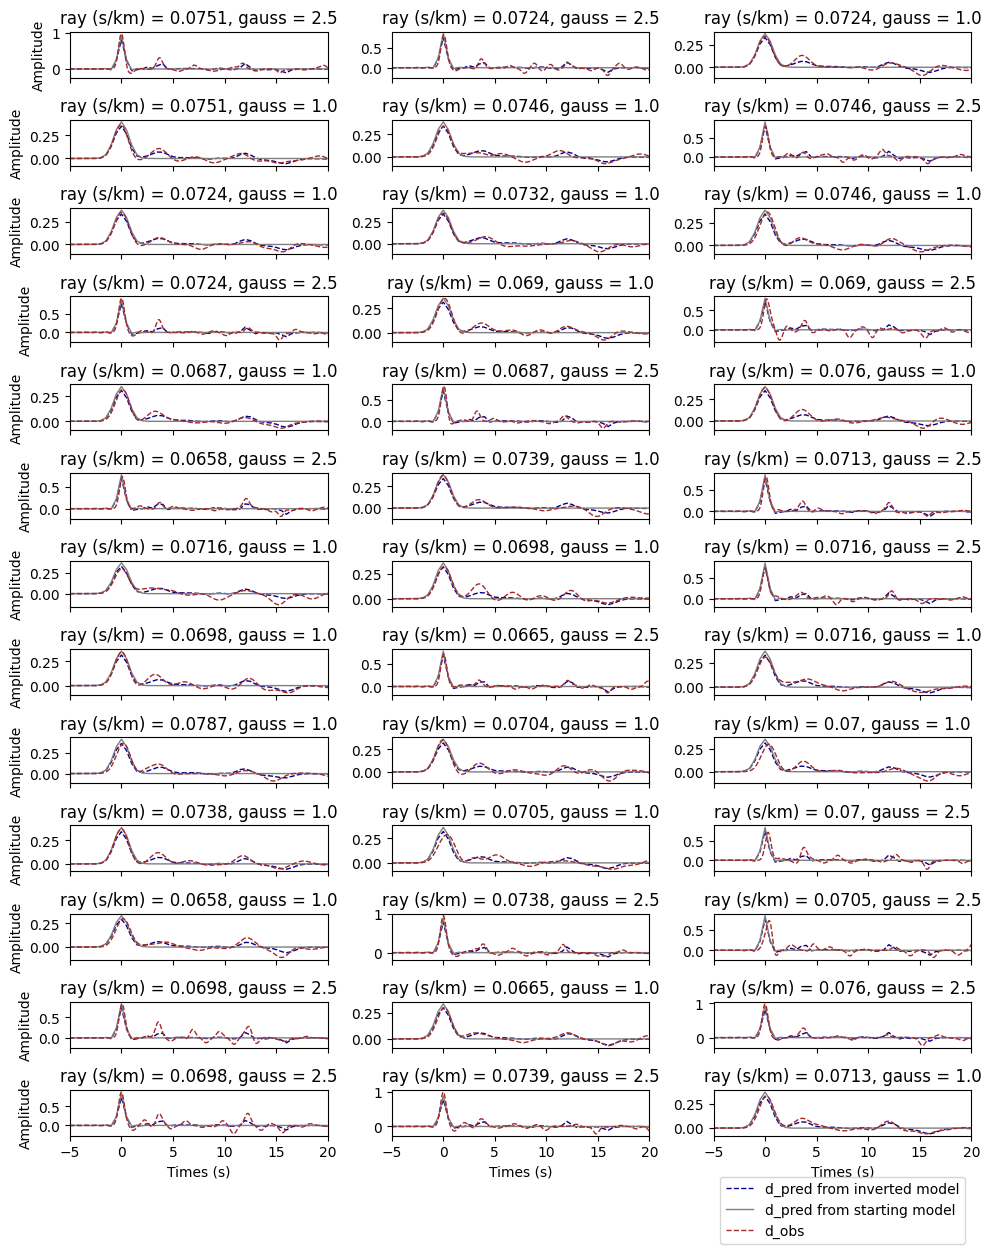

In [44]:
all_rf_dpred = []
all_rf_dpred_init_m = []

for gauss, ray_param in zip(all_gauss, all_ray_params):
    dpred = forward_rf_interp(inv_res_optimiser_field.model, gauss, ray_param)
    all_rf_dpred.append(dpred)
    dpred_init_m = forward_rf_interp(init_model, gauss, ray_param)
    all_rf_dpred_init_m.append(dpred_init_m)

axes = plot_rf_field_data(all_rf_dpred, all_gauss, all_ray_params, rf_field_times,
                          color="darkblue", linestyle="dashed", 
                          label="d_pred from inverted model")
plot_rf_field_data(all_rf_dpred_init_m, all_gauss, all_ray_params, rf_field_times,
                   axes=axes, color="gray",
                   label="d_pred from starting model")
plot_rf_field_data(all_rf_field_dobs, all_gauss, all_ray_params, rf_field_times,
                   axes=axes, color="brown", linestyle="dashed",
                   label="d_obs")

axes[-1,-1].legend(loc="lower center", bbox_to_anchor=(0.5, -2.5));

## Fixed-dimensional sampling

**Prepare `BaseProblem` for fixed-dimensional sampling**

In [45]:
thick_min = 3
thick_max = 10
vs_min = 2
vs_max = 5

def my_log_prior(model):
    thicknesses, vs = split_layercake_model(model)
    thicknesses_out_of_bounds = (thicknesses < thick_min) | (thicknesses > thick_max)
    vs_out_of_bounds = (vs < vs_min) | (vs > vs_max)
    if np.any(thicknesses_out_of_bounds) or np.any(vs_out_of_bounds):
        return float("-inf")
    log_prior = - np.log(thick_max - thick_min) * len(thicknesses) \
                - np.log(vs_max - vs_min) * len(vs)
    return log_prior

In [46]:
# estimate the data noise
rayleigh_dpred = forward_sw_interp(ref_good_model, field_d_periods)
rayleigh_std = np.std(rayleigh_dpred - rayleigh_field_d_obs)
rf_dpred_1_0 = forward_rf_interp(ref_good_model, 1, ray_param_1_0)
rf_1_0_std = np.std(rf_dpred_1_0 - rf_field_dobs_1_0)
rf_dpred_2_5 = forward_rf_interp(ref_good_model, 2.5, ray_param_2_5)
rf_2_5_std = np.std(rf_dpred_2_5 - rf_field_dobs_2_5)

In [47]:
# inverse data covariance matrix
Cdinv_rayleigh = np.eye(len(rayleigh_field_d_obs)) / (rayleigh_std**2)
Cdinv_rf_1_0 = np.eye(len(rf_field_dobs_1_0)) / (rf_1_0_std**2)
Cdinv_rf_2_5 = np.eye(len(rf_field_dobs_2_5)) / (rf_2_5_std**2)

Cdinv_list = [Cdinv_rayleigh, Cdinv_rf_1_0, Cdinv_rf_2_5]

def my_log_likelihood(
    model, 
    fwd_funcs=fwd_funcs, 
    d_obs_list=d_obs_list, 
    Cdinv_list=Cdinv_list
):
    log_like_sum = 0
    for (fwd, fwd_kwargs), d_obs, Cdinv in zip(fwd_funcs, d_obs_list, Cdinv_list):
        try:
            d_pred = fwd(model, **fwd_kwargs)
        except:
            return float("-inf")
        residual = d_obs - d_pred
        log_like_sum += -0.5 * residual @ (Cdinv @ residual).T
    return log_like_sum

In [48]:
n_walkers = 60

my_walkers_start = np.ones((n_walkers, n_dims)) * inv_res_optimiser_field.model
for i in range(n_walkers):
    my_walkers_start[i,:] += np.random.normal(0, 0.5, n_dims)

In [49]:
joint_field_problem.set_log_prior(my_log_prior)
joint_field_problem.set_log_likelihood(my_log_likelihood)

**Define `InversionOptions`**

In [50]:
inv_options_fixed_d_sampling = cofi.InversionOptions()
inv_options_fixed_d_sampling.set_tool("emcee")
inv_options_fixed_d_sampling.set_params(
    nwalkers=n_walkers,
    nsteps=20_000,
    initial_state=my_walkers_start,
    skip_initial_state_check=True,
    progress=True
)

**Define `Inversion` and run**

In [51]:
inv_fixed_d_sampler_field = cofi.Inversion(joint_field_problem, inv_options_fixed_d_sampling)
inv_res_fixed_d_sampler_field = inv_fixed_d_sampler_field.run()

100%|█████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:08<00:00, 2279.67it/s]


In [52]:
labels_v = [f"v{i}" for i in range(n_dims//2+1)]
labels_t = [f"t{i}" for i in range(n_dims//2)]
labels = [0] * n_dims
labels[::2] = labels_v
labels[1::2] = labels_t

sampler = inv_res_fixed_d_sampler_field.sampler
az_idata = az.from_emcee(sampler, var_names=labels)

In [53]:
az_idata.get("posterior")

<xarray.Dataset> Size: 279MB
Dimensions:  (chain: 60, draw: 20000)
Coordinates:
  * chain    (chain) int64 480B 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 160kB 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
Data variables: (12/29)
    v0       (chain, draw) float64 10MB 3.786 3.786 3.786 ... 3.74 3.74 3.74
    t0       (chain, draw) float64 10MB 9.582 9.582 9.582 ... 9.926 9.926 9.926
    v1       (chain, draw) float64 10MB 3.672 3.672 3.672 ... 3.323 3.323 3.323
    t1       (chain, draw) float64 10MB 9.862 9.862 9.862 ... 9.463 9.463 9.463
    v2       (chain, draw) float64 10MB 4.108 4.108 4.108 ... 3.769 3.769 3.769
    t2       (chain, draw) float64 10MB 9.851 9.851 9.851 ... 9.163 9.163 9.163
    ...       ...
    t11      (chain, draw) float64 10MB 9.242 9.242 9.242 ... 10.01 10.01 10.01
    v12      (chain, draw) float64 10MB 3.862 3.862 3.862 ... 3.225 3.225 3.225
    t12      (chain, draw) float64 10MB 9.763 9.763 9.763 ... 10.42 10.42 10.42
    v13      (chain, draw) float64 10MB 4.311 4.311 4.311 ... 4.289 4.289 4.289
    t13      (chain, draw) float64 10MB 9.637 9.637 9.637 ... 9.867 9.867 9.867
    v14      (chain, draw) float64 10MB 5.266 5.266 5.266 ... 4.459 4.459 4.459
Attributes:
    created_at:                 2025-04-18T04:40:12.215195+00:00
    arviz_version:              0.20.0
    inference_library:          emcee
    inference_library_version:  3.1.6

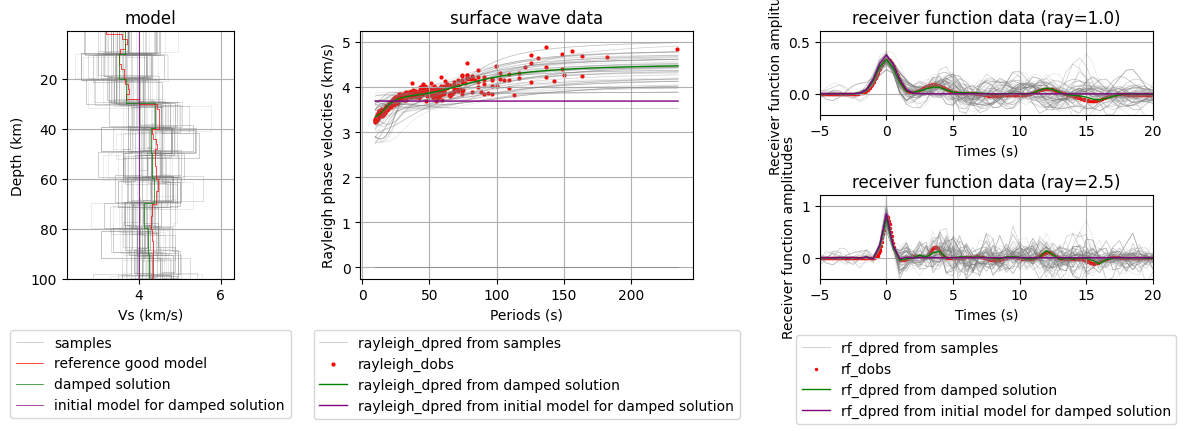

In [54]:
flat_samples = sampler.get_chain(discard=10_000, thin=500, flat=True)
rand_indices = np.random.randint(len(flat_samples), size=100)

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 2])
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 2])

ax1.set_ylim(100)
ax3.set_xlim(-5, 20)
ax3.set_ylim(-0.2, 0.6)
ax4.set_xlim(-5, 20)
ax4.set_ylim(-0.4, 1.2)

# plot samples and data predictions from samples
for idx in rand_indices:
    sample = flat_samples[idx]
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_sw_data(forward_sw_interp(sample, field_d_periods_logspace),
                 field_d_periods_logspace, 
                 ax=ax2, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf_interp(sample, 1, ray_param_1_0), rf_field_times,
                 ax=ax3, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf_interp(sample, 2.5, ray_param_2_5), rf_field_times,
                 ax=ax4, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
sample_0 = flat_samples[rand_indices[0]]
plot_model(sample_0, ax=ax1, alpha=0.5, lw=0.5, color="gray", label="samples")
plot_sw_data(forward_sw_interp(sample_0, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, 
             alpha=0.5, lw=0.5, color="gray", label="rayleigh_dpred from samples")
plot_rf_data(forward_rf_interp(sample_0, 1, ray_param_1_0), rf_field_times, ax=ax3, 
             alpha=0.5, lw=0.5, color="gray", label="rf_dpred from samples")
plot_rf_data(forward_rf_interp(sample_0, 2.5, ray_param_2_5), rf_field_times, ax=ax4, 
             alpha=0.5, lw=0.5, color="gray", label="rf_dpred from samples")

# plot reference good model and data observations
plot_model(ref_good_model, ax=ax1, alpha=1, color="r", label="reference good model")
plot_sw_data(rayleigh_field_d_obs, field_d_periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")
plot_rf_data(rf_field_dobs_1_0, rf_field_times, ax=ax3, scatter=True, color="r", s=2, 
          label="rf_dobs")
plot_rf_data(rf_field_dobs_2_5, rf_field_times, ax=ax4, scatter=True, color="r", s=2, 
          label="rf_dobs")

# plot damped optimisation result
plot_model(inv_res_optimiser_field.model, ax=ax1, alpha=1, color="green", 
           label="damped solution")
plot_sw_data(forward_sw_interp(inv_res_optimiser_field.model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="green",
             label="rayleigh_dpred from damped solution")
plot_rf_data(forward_rf_interp(inv_res_optimiser_field.model, 1, ray_param_1_0), 
             rf_field_times, ax=ax3, color="green",
             label="rf_dpred from damped solution")
plot_rf_data(forward_rf_interp(inv_res_optimiser_field.model, 2.5, ray_param_2_5), 
             rf_field_times, ax=ax4, color="green",
             label="rf_dpred from damped solution")

# plot initial model for dampied optimsiation
plot_model(init_model, ax=ax1, alpha=1, color="purple", 
           label="initial model for damped solution")
plot_sw_data(forward_sw_interp(init_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="purple",
             label="rayleigh_dpred from initial model for damped solution")
plot_rf_data(forward_rf_interp(init_model, 1, ray_param_1_0), rf_field_times, 
             ax=ax3, color="purple",
             label="rf_dpred from initial model for damped solution")
plot_rf_data(forward_rf_interp(init_model, 2.5, ray_param_2_5), rf_field_times, 
             ax=ax4, color="purple",
             label="rf_dpred from initial model for damped solution")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax4.legend(loc="upper center", bbox_to_anchor=(0.5, -0.6))
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax3.set_title("receiver function data (ray=1.0)")
ax4.set_title("receiver function data (ray=2.5)")

plt.tight_layout()

## Trans-dimensional sampling

**Prepare utilities for trans-d sampling**

In [55]:
def fwd_for_bayesbay(state, fwd_func, **kwargs):
    vs = state["voronoi"]["vs"]
    voronoi_sites = state["voronoi"]["discretization"]
    depths = (voronoi_sites[:-1] + voronoi_sites[1:]) / 2
    thicknesses = depths - np.insert(depths[:-1], 0, 0)
    model = form_layercake_model(thicknesses, vs)
    return fwd_func(model, **kwargs)

In [56]:
targets = [
    bayesbay.Target("rayleigh", rayleigh_field_d_obs, covariance_mat_inv=1/rayleigh_std**2),
    bayesbay.Target("rf_1_0", rf_field_dobs_1_0, covariance_mat_inv=1/rf_1_0_std**2), 
    bayesbay.Target("rf_2_5", rf_field_dobs_2_5, covariance_mat_inv=1/rf_2_5_std**2)
]
forward_funcs = [
    (fwd_for_bayesbay, {"fwd_func": forward_sw_interp, "periods": field_d_periods}), 
    (fwd_for_bayesbay, {"fwd_func": forward_rf_interp, "gauss": 1, "ray_param": ray_param_1_0}),
    (fwd_for_bayesbay, {"fwd_func": forward_rf_interp, "gauss": 2.5, "ray_param": ray_param_2_5})
]

my_log_likelihood = bayesbay.LogLikelihood(targets, forward_funcs)

/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/ipykernel_95201/65937161.py:2: DeprecationWarning: The 'Target' class has been moved to the 'likelihood' module. Please use 'from bayesbay.likelihood import Target' instead.
  bayesbay.Target("rayleigh", rayleigh_field_d_obs, covariance_mat_inv=1/rayleigh_std**2),
/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/ipykernel_95201/65937161.py:3: DeprecationWarning: The 'Target' class has been moved to the 'likelihood' module. Please use 'from bayesbay.likelihood import Target' instead.
  bayesbay.Target("rf_1_0", rf_field_dobs_1_0, covariance_mat_inv=1/rf_1_0_std**2),
/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/ipykernel_95201/65937161.py:4: DeprecationWarning: The 'Target' class has been moved to the 'likelihood' module. Please use 'from bayesbay.likelihood import Target' instead.
  bayesbay.Target("rf_2_5", rf_field_dobs_2_5, covariance_mat_inv=1/rf_2_5_std**2)
/var/folders/4c/h8hvkbn17rb36dsylqf_wp44jk123f/T/ipykernel_95201/65937161

In [57]:
param_vs = bayesbay.prior.UniformPrior(
    name="vs", 
    vmin=[2.7, 3.2, 3.75], 
    vmax=[4, 4.75, 5], 
    position=[0, 40, 80], 
    perturb_std=0.15
)

def param_vs_initialize(param, positions): 
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals

param_vs.set_custom_initialize(param_vs_initialize)

In [58]:
parameterization = bayesbay.parameterization.Parameterization(
    bayesbay.discretization.Voronoi1D(
        name="voronoi", 
        vmin=0, 
        vmax=150, 
        perturb_std=10, 
        n_dimensions=None, 
        n_dimensions_min=4, 
        n_dimensions_max=15, 
        parameters=[param_vs], 
    )
)
my_perturbation_funcs = parameterization.perturbation_funcs

In [59]:
n_chains=12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(parameterization.initialize())

**Define `InversionOptions`**

In [60]:
inv_options_trans_d = cofi.InversionOptions()
inv_options_trans_d.set_tool("bayesbay")
inv_options_trans_d.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=my_perturbation_funcs,
    log_like_ratio_func=my_log_likelihood,
    n_chains=n_chains, 
    n_iterations=2_000, 
    burnin_iterations=1_000,
    verbose=False, 
    save_every=200, 
)

**Define `Inversion` and run**

In [61]:
inv_trans_d_sampler_field = cofi.Inversion(joint_field_problem, inv_options_trans_d)
inv_res_trans_d_sampler_field = inv_trans_d_sampler_field.run()

In [62]:
saved_states = inv_res_trans_d_sampler_field.models
samples_voronoi = saved_states["voronoi.discretization"]
samples_vs = saved_states["voronoi.vs"]
interp_depths = np.arange(150, dtype=float)

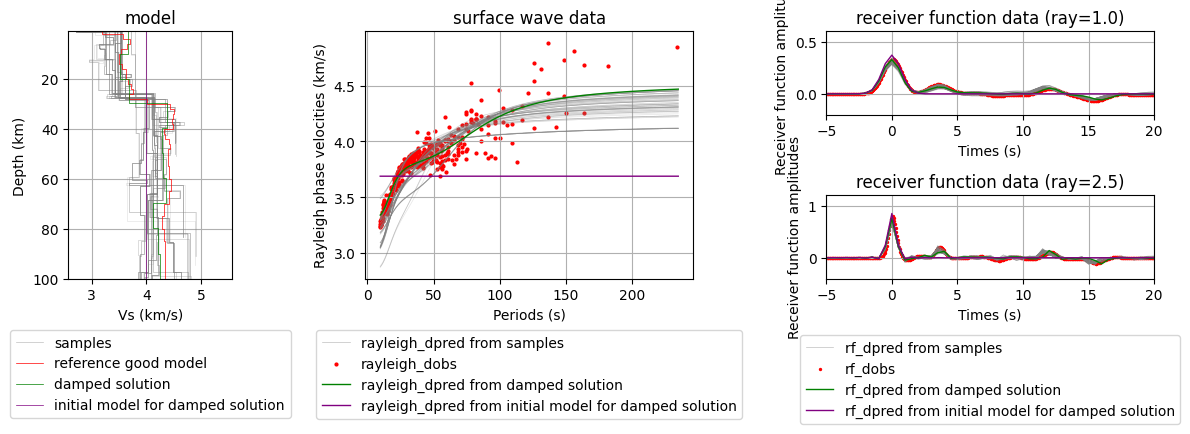

In [63]:
rand_indices = np.random.randint(len(samples_voronoi), size=100)

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 2])
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 2])

ax1.set_ylim(100)
ax3.set_xlim(-5, 20)
ax3.set_ylim(-0.2, 0.6)
ax4.set_xlim(-5, 20)
ax4.set_ylim(-0.4, 1.2)

# plot samples and data predictions from samples
for idx in rand_indices:
    sample_voronoi = form_voronoi_model(samples_voronoi[idx], samples_vs[idx])
    sample = voronoi_to_layercake(sample_voronoi)
    plot_model(sample, ax=ax1, alpha=0.2, lw=0.5, color="gray")
    plot_sw_data(forward_sw_interp(sample, field_d_periods_logspace),
                 field_d_periods_logspace, 
                 ax=ax2, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf_interp(sample, 1, ray_param_1_0), rf_field_times,
                 ax=ax3, alpha=0.2, lw=0.5, color="gray")
    plot_rf_data(forward_rf_interp(sample, 2.5, ray_param_2_5), rf_field_times,
                 ax=ax4, alpha=0.2, lw=0.5, color="gray")

# add labels to samples
sample_0_voronoi = form_voronoi_model(samples_voronoi[0], samples_vs[0])
sample_0 = voronoi_to_layercake(sample_0_voronoi)
plot_model(sample_0, ax=ax1, alpha=0.5, lw=0.5, color="gray", label="samples")
plot_sw_data(forward_sw_interp(sample_0, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, 
             alpha=0.5, lw=0.5, color="gray", label="rayleigh_dpred from samples")
plot_rf_data(forward_rf_interp(sample_0, 1, ray_param_1_0), rf_field_times, ax=ax3, 
             alpha=0.5, lw=0.5, color="gray", label="rf_dpred from samples")
plot_rf_data(forward_rf_interp(sample_0, 2.5, ray_param_2_5), rf_field_times, ax=ax4, 
             alpha=0.5, lw=0.5, color="gray", label="rf_dpred from samples")

# plot reference good model and data observations
plot_model(ref_good_model, ax=ax1, alpha=1, color="r", label="reference good model")
plot_sw_data(rayleigh_field_d_obs, field_d_periods, ax=ax2, scatter=True, color="r", s=4, 
          label="rayleigh_dobs")
plot_rf_data(rf_field_dobs_1_0, rf_field_times, ax=ax3, scatter=True, color="r", s=2, 
          label="rf_dobs")
plot_rf_data(rf_field_dobs_2_5, rf_field_times, ax=ax4, scatter=True, color="r", s=2, 
          label="rf_dobs")

# plot damped optimisation result
plot_model(inv_res_optimiser_field.model, ax=ax1, alpha=1, color="green", 
           label="damped solution")
plot_sw_data(forward_sw_interp(inv_res_optimiser_field.model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="green",
             label="rayleigh_dpred from damped solution")
plot_rf_data(forward_rf_interp(inv_res_optimiser_field.model, 1, ray_param_1_0), 
             rf_field_times, ax=ax3, color="green",
             label="rf_dpred from damped solution")
plot_rf_data(forward_rf_interp(inv_res_optimiser_field.model, 2.5, ray_param_2_5), 
             rf_field_times, ax=ax4, color="green",
             label="rf_dpred from damped solution")

# plot initial model for dampied optimsiation
plot_model(init_model, ax=ax1, alpha=1, color="purple", 
           label="initial model for damped solution")
plot_sw_data(forward_sw_interp(init_model, field_d_periods_logspace), 
             field_d_periods_logspace, ax=ax2, color="purple",
             label="rayleigh_dpred from initial model for damped solution")
plot_rf_data(forward_rf_interp(init_model, 1, ray_param_1_0), rf_field_times, 
             ax=ax3, color="purple",
             label="rf_dpred from initial model for damped solution")
plot_rf_data(forward_rf_interp(init_model, 2.5, ray_param_2_5), rf_field_times, 
             ax=ax4, color="purple",
             label="rf_dpred from initial model for damped solution")

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax4.legend(loc="upper center", bbox_to_anchor=(0.5, -0.6))
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax3.set_title("receiver function data (ray=1.0)")
ax4.set_title("receiver function data (ray=2.5)")

plt.tight_layout()

----
## Watermark

In [64]:
watermark_list = ["cofi", "numpy", "matplotlib", "scipy", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
numpy 2.1.3
matplotlib 3.10.1
scipy 1.14.1
bayesbay 0.3.1
